In [1]:
import torch
from PIL import Image
from torchvision import transforms, models
from sys import version
import timm
from tqdm import tqdm
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler as Slearn_Scaler
import seaborn as sns
from functools import reduce
from math import sqrt, floor, ceil, prod
from numpy import linspace
from math import floor, ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter
import inspect
import pickle
import pandas as pd
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import cm
from itertools import cycle
import logging
import matplotlib.ticker as mtick
from collections import Counter
from numpy.lib.stride_tricks import sliding_window_view
from math import floor
import multiprocessing
import os
from tqdm.contrib.concurrent import process_map  
from itertools import repeat

logging.getLogger('matplotlib').setLevel(logging.ERROR)
%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')
version

'3.9.5 (default, Apr 15 2022, 15:04:02) \n[GCC 8.4.0]'

In [87]:
sns.set_style("darkgrid")

In [81]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties.index.get_level_values(level=0).drop_duplicates()

Index(['dla46x_c', 'tf_efficientnet_b0', 'swsl_resnext101_32x8d',
       'efficientnet_b8', 'tf_efficientnetv2_l_in21k', 'ese_vovnet19b_slim',
       'xcit_medium_24_p8_384_dist', 'botnet26t_256', 'resnest14d',
       'res2net50_48w_2s',
       ...
       'resnetblur18', 'crossvit_15_dagger_408', 'regnetx_120',
       'eca_vovnet39b', 'haloregnetz_b', 'dla169', 'hardcorenas_a',
       'gmixer_24_224', 'cspresnet50w', 'regnetx_064'],
      dtype='object', length=695)

/tmp/ipykernel_205078/1669569973.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  layer_properties = single_idx[layer_properties.groupby(level=0).size() > 1]


Index(['dla46x_c', 'tf_efficientnet_b0', 'swsl_resnext101_32x8d',
       'efficientnet_b8', 'tf_efficientnetv2_l_in21k', 'ese_vovnet19b_slim',
       'xcit_medium_24_p8_384_dist', 'botnet26t_256', 'resnest14d',
       'res2net50_48w_2s',
       ...
       'resnetblur18', 'crossvit_15_dagger_408', 'regnetx_120',
       'eca_vovnet39b', 'haloregnetz_b', 'dla169', 'hardcorenas_a',
       'gmixer_24_224', 'cspresnet50w', 'regnetx_064'],
      dtype='object', name='level_0', length=680)

/tmp/ipykernel_205078/4143098553.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  layer_properties = single_idx[layer_properties.groupby(level=0).size() > 1]


,MAC Reuse
Reuse Type,
fmap_reuse,384.0
ofmap_reuse,196.0
weight_reuse,256.0


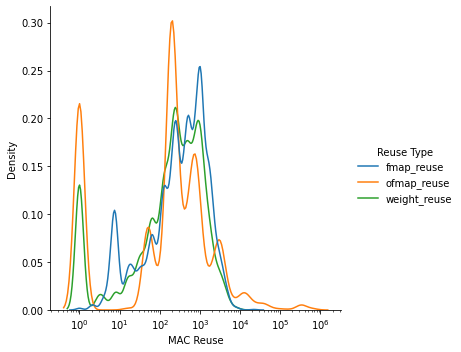

In [82]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
# layer_properties = layer_properties[layer_properties['type'] == 'conv']

new_records = []
for record in layer_properties[['avg_ifmap_reuse', 'avg_weight_reuse', 'avg_ofmap_reuse']].to_records():
    new_records.append((record[0], record[1], 'fmap_reuse', record[2]))
    new_records.append((record[0], record[1], 'ofmap_reuse', record[3]))
    new_records.append((record[0], record[1], 'weight_reuse', record[4]))
df = pd.DataFrame.from_records(new_records, columns=['Model Name', 'Layer Name', 'Reuse Type', 'MAC Reuse'])
plt = sns.displot(data = df, x = 'MAC Reuse', hue='Reuse Type', log_scale=True, kind='kde')
df[['MAC Reuse', 'Reuse Type']].groupby('Reuse Type').quantile(q=0.5)

In [126]:
def interpolate_layer_metric(
    layer_properties: pd.DataFrame, metric_type: str, longest_network_length: int
):
    layer_prop_dict = layer_properties.to_dict(orient="index")
    mem_sizes = {}
    for (model_name, _), properties in layer_prop_dict.items():
        size = properties[metric_type]
        try:
            mem_sizes[model_name].append(size)
        except KeyError as e:
            mem_sizes[model_name] = [size]
    interp_sizes = {}
    for model_name, values in mem_sizes.items():
        model_length = len(values)
        if model_length == 1:
            continue
        idx_list = np.linspace(0, longest_network_length, model_length)
        interp = np.interp(
            x = np.arange(longest_network_length), xp = idx_list, fp = values
        )
        interp_sizes[model_name] = interp
    return interp_sizes

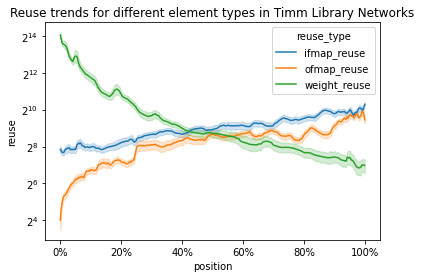

In [129]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
longest_network_length = layer_properties.groupby(level=0).size().max()

interpolate_layer_metric(layer_properties, 'avg_ifmap_reuse', longest_network_length)


interp_ifmap_reuse = interpolate_layer_metric(
    layer_properties, "avg_ifmap_reuse", longest_network_length
)
interp_ofmap_reuse = interpolate_layer_metric(
    layer_properties, "avg_ofmap_reuse", longest_network_length
)
interp_weight_reuse = interpolate_layer_metric(
    layer_properties, "avg_weight_reuse", longest_network_length
)

interp_reuse = {
    model_name: {
        "ifmap_reuse": interp_ifmap_reuse[model_name],
        "ofmap_reuse": interp_ofmap_reuse[model_name],
        "weight_reuse": interp_weight_reuse[model_name],
    }
    for model_name in interp_ifmap_reuse.keys()
}
interp_sizes_as_records = []
for model_name, reuse in interp_reuse.items():
    for idx, (ifmap_reuse, ofmap_reuse, weight_reuse) in enumerate(
        zip(reuse["ifmap_reuse"], reuse["ofmap_reuse"], reuse["weight_reuse"])
    ):
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "ifmap_reuse",
                "reuse": ifmap_reuse,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "ofmap_reuse",
                "reuse": ofmap_reuse,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "weight_reuse",
                "reuse": weight_reuse,
            }
        )
df = pd.DataFrame.from_records(interp_sizes_as_records).sort_values(['model_name', 'position'])
plt = sns.lineplot(
    data=df, x="position", y="reuse", hue='reuse_type', ci=99
)
plt.set_yscale('log', base = 2)
plt.set_title('Reuse trends for different element types in Timm Library Networks')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())

/tmp/ipykernel_205078/2234362335.py:22: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  np.log2(df.groupby('Size Type').quantile(q=0.85))


,Size
Size Type,
fmap,19.007027
ofmap,19.614710
weight,20.000000


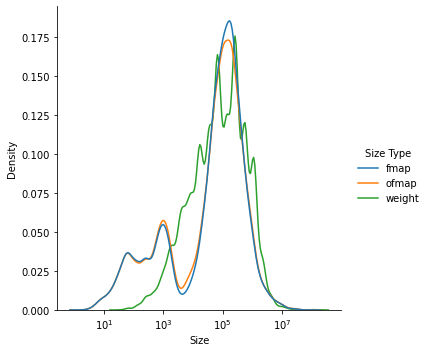

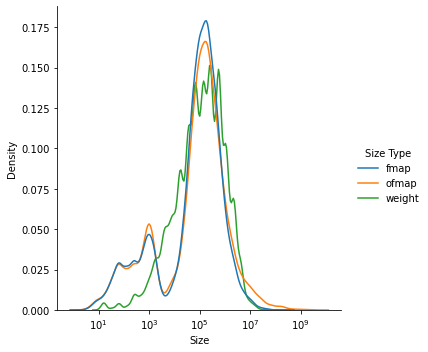

In [29]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

new_records = []
for record in layer_properties[['original_ifmap_mem_size', 'original_ofmap_mem_size', 'original_weight_mem_size']].to_records():
    new_records.append((record[0], record[1], 'fmap', record[2]))
    new_records.append((record[0], record[1], 'ofmap', record[3]))
    new_records.append((record[0], record[1], 'weight', record[4]))
df = pd.DataFrame.from_records(new_records, columns=['Model Name', 'Layer Name', 'Size Type', 'Size'])
plt = sns.displot(data = df, x = 'Size', hue='Size Type', log_scale=True, kind='kde')

layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
# layer_properties = layer_properties[layer_properties['type'] == 'conv']

new_records = []
for record in layer_properties[['ifmap_mem_size', 'ofmap_mem_size', 'weight_mem_size']].to_records():
    new_records.append((record[0], record[1], 'fmap', record[2]))
    new_records.append((record[0], record[1], 'ofmap', record[3]))
    new_records.append((record[0], record[1], 'weight', record[4]))
df = pd.DataFrame.from_records(new_records, columns=['Model Name', 'Layer Name', 'Size Type', 'Size'])
plt = sns.displot(data = df, x = 'Size', hue='Size Type', log_scale=True, kind='kde')
np.log2(df.groupby('Size Type').quantile(q=0.85))


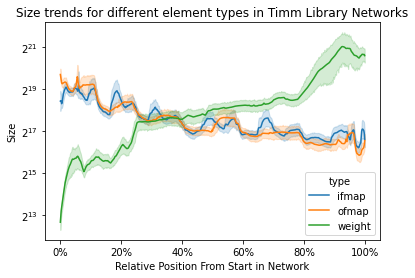

In [127]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']


longest_network_length = layer_properties.groupby(level=0).size().max()
interp_ifmap_sizes = interpolate_layer_metric(
    layer_properties, "original_ifmap_mem_size", longest_network_length
)
interp_ofmap_sizes = interpolate_layer_metric(
    layer_properties, "original_ofmap_mem_size", longest_network_length
)
interp_weight_sizes = interpolate_layer_metric(
    layer_properties, "original_weight_mem_size", longest_network_length
)
interp_ifmap_sizes

interp_sizes = {
    model_name: {
        "ifmap_mem": interp_ifmap_sizes[model_name],
        "ofmap_mem": interp_ofmap_sizes[model_name],
        "weight_mem": interp_weight_sizes[model_name],
    }
    for model_name in interp_ifmap_sizes.keys()
}
interp_sizes_as_records = []
for model_name, sizes in interp_sizes.items():
    for idx, (ifmap_size, ofmap_size, weight_mem) in enumerate(
        zip(sizes["ifmap_mem"], sizes["ofmap_mem"], sizes["weight_mem"])
    ):
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "ifmap",
                "size": ifmap_size,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "ofmap",
                "size": ofmap_size,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "type": "weight",
                "size": weight_mem,
            }
        )
df = pd.DataFrame.from_records(interp_sizes_as_records).sort_values(['model_name', 'position'])
df.rename(columns={'position': "Relative Position From Start in Network", "size": "Size"}, inplace = True)
plt = sns.lineplot(
    data=df, x="Relative Position From Start in Network", y="Size", hue='type', ci=99
)
plt.set_yscale('log', base = 2)
plt.set_title('Size trends for different element types in Timm Library Networks')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())


Text(0.5, 1.0, 'Frequency of kernel sizes in timm Library Layers')

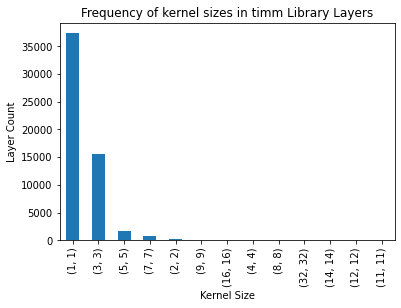

In [32]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
freq = layer_properties['kernel_size'].value_counts()
plt = freq.plot(kind='bar')
plt.set_xlabel('Kernel Size')
plt.set_ylabel('Layer Count')
plt.set_title('Frequency of kernel sizes in timm Library Layers')


Text(0.5, 1.0, 'Networks With At Least One Layer with Kernel Size (k, k)')

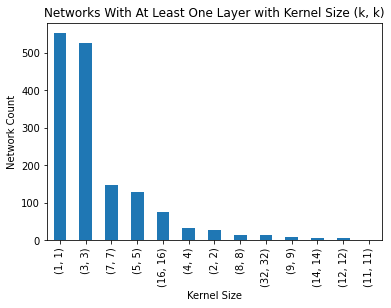

In [33]:

layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
kernel_sizes = layer_properties['kernel_size'].unique()

series = (layer_properties['kernel_size'].groupby(level=0).value_counts())
records = []

kernel_default_counter = Counter(kernel_sizes)
kernel_default_counter.subtract(kernel_default_counter)
kernel_default_counter = dict(kernel_default_counter)
model_counter = {}
for (model_name, kernel_size), freq in series.iteritems():
    try:
        model_counter[model_name][kernel_size] += 1
    except KeyError as e:
        model_counter[model_name] = kernel_default_counter.copy()
        model_counter[model_name][kernel_size] += 1
df = pd.DataFrame.from_dict(model_counter, orient='index')
plt = df.sum(axis=0).sort_values(ascending=False).plot(kind='bar')
plt.set_xlabel('Kernel Size')
plt.set_ylabel('Network Count')
plt.set_title('Networks With At Least One Layer with Kernel Size (k, k)')

Text(0.5, 1.0, 'Boxplot of Kernel Size vs MACS for Timm Library Networks')

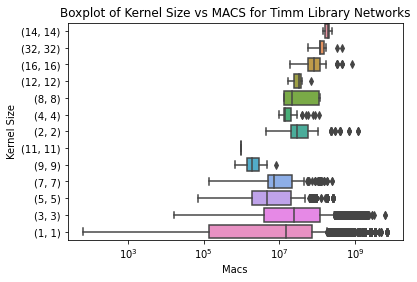

In [34]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

macs_vs_ksize = layer_properties[["original_macs", "kernel_size"]].copy()
macs_vs_ksize.rename(columns={"kernel_size": "Kernel Size", "original_macs": "Macs"}, inplace=True)
plt = sns.boxplot(
    data=macs_vs_ksize,
    y="Kernel Size",
    x="Macs",
    order=macs_vs_ksize.groupby("Kernel Size").min().sort_values(by="Macs", ascending=False).index,
)
plt.set_xscale('log', base=10)
plt.set_title('Boxplot of Kernel Size vs MACS for Timm Library Networks')



Text(0.5, 1.0, "Boxplot of Kernel Size vs MACS for Timm Library Networks Weighted by a Kernel's frequency of occurence")

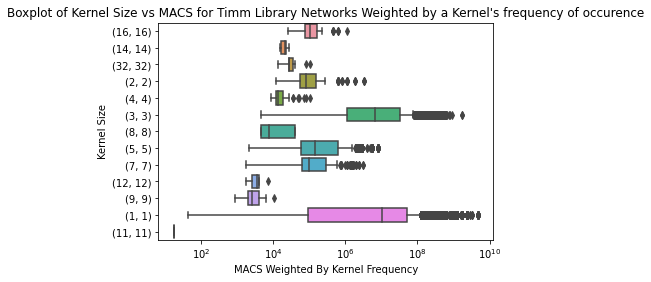

In [35]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

macs_vs_ksize = layer_properties[["original_macs", "kernel_size"]]
freq = layer_properties["kernel_size"].value_counts()
macs_vs_ksize = macs_vs_ksize.assign(kernel_multipler=1)
for idx in freq.index:
    filtered_df = macs_vs_ksize[macs_vs_ksize["kernel_size"] == idx]
    macs_vs_ksize.loc[
        macs_vs_ksize.index.isin(filtered_df.index), "kernel_multipler"
    ] = freq[idx]
macs_vs_ksize["weighted_macs"] = (
    macs_vs_ksize["original_macs"] * macs_vs_ksize["kernel_multipler"] / np.sum(freq.values)
)
macs_vs_ksize.rename(columns={"kernel_size": "Kernel Size", "original_macs": "Macs", "weighted_macs": "MACS Weighted By Kernel Frequency"}, inplace=True)

plt = sns.boxplot(
    data=macs_vs_ksize,
    y="Kernel Size",
    x="MACS Weighted By Kernel Frequency",
    order=macs_vs_ksize.groupby("Kernel Size").min().sort_values(by="MACS Weighted By Kernel Frequency", ascending=False).index,
)
plt.set_xscale('log', base=10)
plt.set_title('Boxplot of Kernel Size vs MACS for Timm Library Networks Weighted by a Kernel\'s frequency of occurence')


/tmp/ipykernel_144530/569194365.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_x.set_xticklabels(
/tmp/ipykernel_144530/569194365.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.ax_marg_y.set_yticklabels(


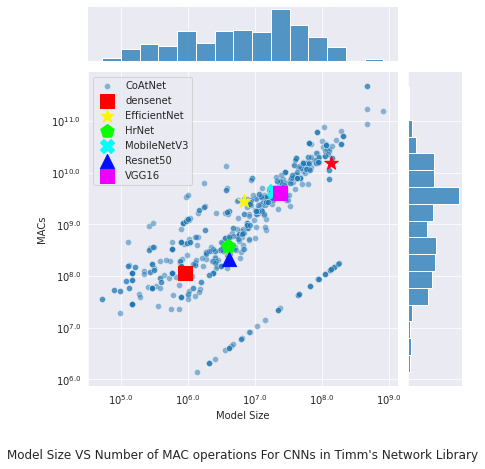

In [147]:
highlighted_models = {
    "vgg16": "VGG16",
    "resnet50": "Resnet50",
    "mobilenetv3_rw": "MobileNetV3",
    "efficientnet_b0": "EfficientNet",
    "coat_lite_small": "CoAtNet",
    "densenet121": "densenet",
    "hrnet_w18": "HrNet",
}

layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']

df = layer_properties[["original_macs", "weight_mem_size"]].groupby(level=0).sum()
df = np.log10(df)

df.rename(columns={"original_macs": "MACs", "weight_mem_size": "Model Size"}, inplace=True)
plt = sns.jointplot(data=df, y="MACs", x="Model Size", alpha=0.5)
plt.ax_marg_x.set_xticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_x.get_xticks()]
)
plt.ax_marg_y.set_yticklabels(
    [r"$10^{" + str(i) + "}$" for i in plt.ax_marg_y.get_yticks()]
)
plt.ax_joint.set_title(
    "Model Size VS Number of MAC operations For CNNs in Timm's Network Library", y=-0.25
)
color_iter = iter(cm.hsv(np.linspace(0, 1, len(highlighted_models))))
marker_iter = cycle(["o", "D", "s", "*", "p", "X", "^"])

legend = []
for model_name, macs, size in df.to_records():
    if model_name in highlighted_models.keys():
        legend.append(highlighted_models[model_name])
        plt.ax_joint.scatter(
            x=size, y=macs, marker=next(marker_iter), color=next(color_iter), s=200
        )
plt.ax_joint.legend(legend)


In [16]:
cpu_profiling = pd.read_csv('../data/cpu_model_profiling.csv', index_col=[0])
supported_fwd = cpu_profiling[cpu_profiling['Unnamed: 1'] == 'supported_forward']['Duration']
fwd = cpu_profiling[cpu_profiling['Unnamed: 1'] == 'forward']['Duration']
cpu_profiling = pd.read_csv('../data/cpu_model_profiling.csv', index_col=[0, 1])
cpu_profiling_dict = cpu_profiling.to_dict(orient='index')
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])



In [64]:
new_dict = {}
for layer_id, runtime_info in cpu_profiling_dict.items():
    model_name, layer_name = layer_id
    try: 
        layer_type = layer_properties['type'][layer_id]
    except KeyError as e:
        continue
    
    new_dict[layer_id] = {
        "prcnt_fwd": runtime_info["Duration"] / fwd[model_name],
        "prcnt_sup_fwd": runtime_info["Duration"]
        / supported_fwd[model_name],
        'type': layer_type
    }
df = pd.DataFrame.from_dict(new_dict, orient='index')

In [ ]:
layer_properties = pd.read_csv("../data/layer_metrics.csv", index_col=[0, 1])
layer_properties = layer_properties[layer_properties['type'] == 'conv']
longest_network_length = layer_properties.groupby(level=0).size().max()

interpolate_layer_metric(layer_properties, 'avg_ifmap_reuse', longest_network_length)


interp_ifmap_reuse = interpolate_layer_metric(
    layer_properties, "avg_ifmap_reuse", longest_network_length
)
interp_ofmap_reuse = interpolate_layer_metric(
    layer_properties, "avg_ofmap_reuse", longest_network_length
)
interp_weight_reuse = interpolate_layer_metric(
    layer_properties, "avg_weight_reuse", longest_network_length
)

interp_reuse = {
    model_name: {
        "ifmap_reuse": interp_ifmap_reuse[model_name],
        "ofmap_reuse": interp_ofmap_reuse[model_name],
        "weight_reuse": interp_weight_reuse[model_name],
    }
    for model_name in interp_ifmap_reuse.keys()
}
interp_sizes_as_records = []
for model_name, reuse in interp_reuse.items():
    for idx, (ifmap_reuse, ofmap_reuse, weight_reuse) in enumerate(
        zip(reuse["ifmap_reuse"], reuse["ofmap_reuse"], reuse["weight_reuse"])
    ):
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "ifmap_reuse",
                "reuse": ifmap_reuse,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "ofmap_reuse",
                "reuse": ofmap_reuse,
            }
        )
        interp_sizes_as_records.append(
            {
                "model_name": model_name,
                "position": idx / longest_network_length * 100,
                "reuse_type": "weight_reuse",
                "reuse": weight_reuse,
            }
        )
df = pd.DataFrame.from_records(interp_sizes_as_records).sort_values(['model_name', 'position'])
plt = sns.lineplot(
    data=df, x="position", y="reuse", hue='reuse_type', ci=99
)
plt.set_yscale('log', base = 2)
plt.set_title('Reuse trends for different element types in Timm Library Networks')
plt.xaxis.set_major_formatter(mtick.PercentFormatter())


In [128]:
total_df = df.reset_index().groupby(['level_0', 'type']).sum()
total_df = total_df.reset_index()
conv_df = pd.DataFrame(total_df[total_df['type'] =='conv'].set_index('level_0')['prcnt_fwd'])
linear_df = pd.DataFrame(total_df[total_df['type'] =='linear'].set_index('level_0')['prcnt_fwd'])
# plotable_df = plotable_df.join(pd.DataFrame(total_df[total_df['type'] =='linear'].set_index('level_0')['prcnt_fwd']))
# total_df.rename(columns={'prcnt_fwd': ''}, inplace=True)
conv_df.plot(kind='pie')
linear_df.plot(kind='pie')

KeyError: 'level_0'